In [2]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
import os

sns.set_style("white")
sns.set_palette("husl")


In [3]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [4]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.experiment_name = experiment_name
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}, lr={}".format(self.experiment_name,
                                                      self.strategy,
                                                          self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            if self.top_k == 1:
                label = "Baseline"
            else:
                label = "Selective-Backprop"
        elif self.strategy == "baseline":
            label = "{}, {}, {}, bs={}, lr={}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k, 
                                                   self.lr) 

        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    

In [5]:
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    #plot_file = "{}.png".format(plot_file_prefix)
    #plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * .8)
    plt.tick_params(axis='x', which='major', labelsize=label_size)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * .8)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size*1.5})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)

In [6]:

def plot(xs_by_config, ys_by_config, xlabel, ylabel, plot_dir, smoothing=0, lw=1, ymin=None, xlim=None):
    xmax = - float("inf")
    ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]

        label = config.label
        print xlabel, ",", ylabel, len(xs), len(ys)
        plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9)
        if max(xs) > xmax:
            xmax = max(xs)
        if max(ys) > ymax:
            ymax = max(ys)
        if xlim:
            plt.xlim(0, xlim)
    
    if len(ys_by_config.keys()) > 0:
        if ymin is not None:
            plt.ylim(ymin, ymax)
        if ylabel == "Test Accuracy":
            plt.ylim(70, ymax)
        if ylabel == "Aggregate Ratio Backpropped":
            plt.ylim(0, 1.5)
        plot_prefix = "{}/{}_{}_lr{}".format(plot_dir,
                                             config.experiment_name,
                                            ylabel,
                                            config.lr)
        format_plot(xlabel, ylabel)
        write_file(plot_prefix, show=True)



In [7]:
def plot_experiments(experiment_names,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     sampling_mins=None,
                     smoothing=0,
                     xlim=None):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store":
                continue
            elif filename == "pickles":
                continue

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue

            train_num_backprops = [l.num_backprop for l in train_lines]
            test_num_backprops = [l.num_backprop for l in test_lines]
            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            ratio_backpropped_ys = [l.num_backprop / float(l.num_backprop + l.num_skip) \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]
            ratio_backpropped_xs = [l.num_backprop \
                                           for l in test_lines \
                                           if (l.num_backprop + l.num_skip) > 0]

            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Backpropped", "Aggregate Ratio Backpropped", plot_dir, smoothing, lw=3, ymin=0, xlim=xlim)
    plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Backpropped", "Training Loss", plot_dir, smoothing, lw=1, xlim=xlim)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Backpropped", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=0, xlim=xlim)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Backpropped", "Test Loss", plot_dir, smoothing, lw=1, xlim=xlim)

In [8]:
def plot_image_distributions(experiment_name, pickles_dir, plot_dir, epoch=None, trials=None):
    print("In plot_image_distributions for {}".format(plot_dir))
    for filename in os.listdir(pickles_dir):
        config = Config(filename, experiment_name)
        if trials:
            if config.trial not in trials:
                continue
        if epoch and "epoch_{}".format(epoch) not in filename:
            continue
        pickles_file = os.path.join(pickles_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            n, bins, patches = plt.hist(d.values(),
                                        50,
                                        normed=0,
                                        alpha=0.75)

            plt.xlim(0, max(d.values()) + 1)
            format_plot("Number of Backprops", "Number of Images")

            subplot_dir = os.path.join(plot_dir, "images_dist")
            if not os.path.isdir(subplot_dir):
                os.mkdir(subplot_dir)
            plt.tight_layout()
            plot_prefix = os.path.join(subplot_dir, filename)
            write_file(plot_prefix) 


deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial3_v2
deterministic_cifar10_resnet_.4_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_.4_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_.4_32_0.001_0.0005_trial3_v2
sampling_cifar10_resnet_.1_32_0.001_0.0005_trial1_v2
sampling_cifar10_resnet_.1_32_0.001_0.0005_trial2_v2
sampling_cifar10_resnet_.1_32_0.001_0.0005_trial3_v2
sampling_cifar10_resnet_1_32_0.001_0.0005_trial1_v2
Num Images Backpropped , Aggregate Ratio Backpropped 11494 11494
Num Images Backpropped , Aggregate Ratio Backpropped 6292 6292


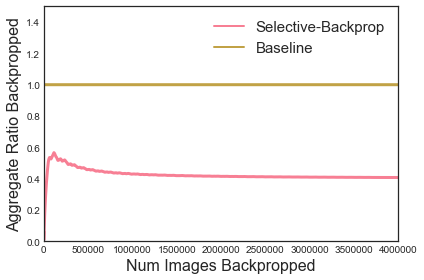

Num Images Backpropped , Training Loss 45477 45477
Num Images Backpropped , Training Loss 61465 61465


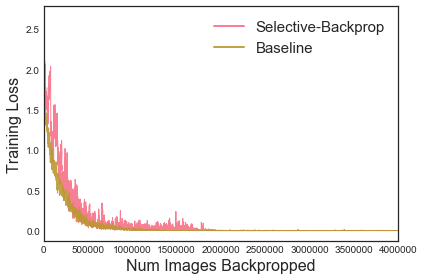

Num Images Backpropped , Test Accuracy 11495 11495
Num Images Backpropped , Test Accuracy 6293 6293


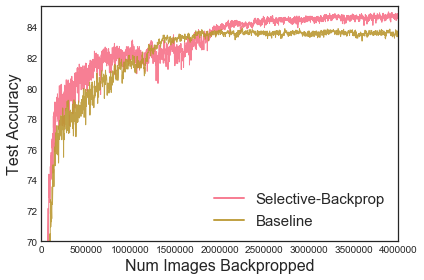

Num Images Backpropped , Test Loss 11495 11495
Num Images Backpropped , Test Loss 6293 6293


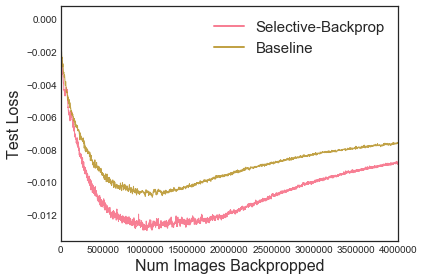

<Figure size 432x288 with 0 Axes>

In [9]:
plot_home_dir = "/Users/angela/research/filtered-training-presentations/pdl18/figs"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/181014_refactor/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["181014_square", "181014_baseline_recenter"]
plot_experiments(experiment_names,
                 experiment_dir,
                 plot_dir,
                 nets=["resnet"],
                 lrs=[0.001, 0.01, 0.1],
                 trials=[1],
                 sampling_mins=[0.4, 1],
                 xlim=4000000,
                 smoothing=1)


deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial3_v2
deterministic_cifar10_resnet_.4_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_1_32_0.001_0.0005_trial1_v2
deterministic_cifar10_resnet_1_32_0.001_0.0005_trial2_v2
deterministic_cifar10_resnet_1_32_0.001_0.0005_trial3_v2
Num Images Backpropped , Aggregate Ratio Backpropped 5846 5846
Num Images Backpropped , Aggregate Ratio Backpropped 6349 6349


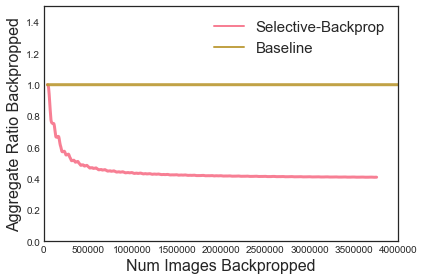

Num Images Backpropped , Training Loss 23511 23511
Num Images Backpropped , Training Loss 62450 62450


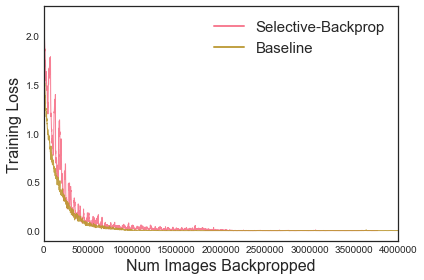

Num Images Backpropped , Test Accuracy 5847 5847
Num Images Backpropped , Test Accuracy 6350 6350


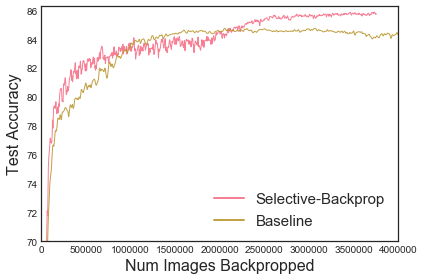

Num Images Backpropped , Test Loss 5847 5847
Num Images Backpropped , Test Loss 6350 6350


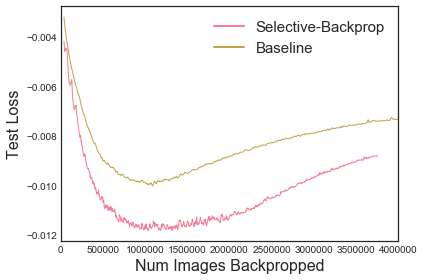

<Figure size 432x288 with 0 Axes>

In [17]:
plot_home_dir = "/Users/angela/research/filtered-training-presentations/pdl18/figs"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/181016_notransform/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["181016_notransform_square", "181016_notransform_baseline_translate"]
plot_experiments(experiment_names,
                 experiment_dir,
                 plot_dir,
                 nets=["resnet"],
                 lrs=[0.001, 0.01, 0.1],
                 sampling_mins=[0.4, 1],
                 trials=[1],
                 smoothing=50,
                 xlim=4000000)


sampling_mnist_lecunn_.1_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_.1_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_.1_32_0.001_0.0005_trial3_v2
sampling_mnist_lecunn_.2_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_.2_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_.2_32_0.001_0.0005_trial3_v2
sampling_mnist_lecunn_.4_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_.4_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_.4_32_0.001_0.0005_trial3_v2
sampling_mnist_lecunn_0.6_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_0.6_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_0.6_32_0.001_0.0005_trial3_v2
sampling_mnist_lecunn_1_32_0.001_0.0005_trial1_v2
sampling_mnist_lecunn_1_32_0.001_0.0005_trial2_v2
sampling_mnist_lecunn_1_32_0.001_0.0005_trial3_v2
Num Images Backpropped , Aggregate Ratio Backpropped 4243 4243
Num Images Backpropped , Aggregate Ratio Backpropped 632 632


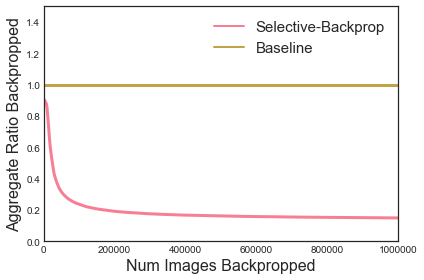

Num Images Backpropped , Training Loss 6250 6250
Num Images Backpropped , Training Loss 6250 6250


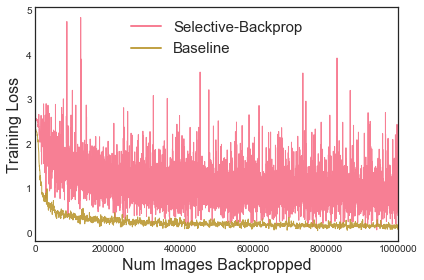

Num Images Backpropped , Test Accuracy 4244 4244
Num Images Backpropped , Test Accuracy 633 633


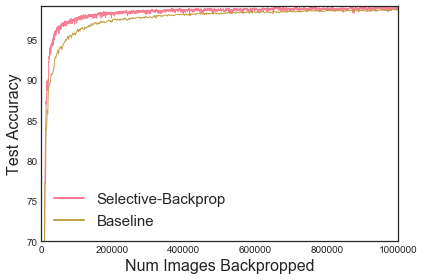

Num Images Backpropped , Test Loss 4244 4244
Num Images Backpropped , Test Loss 633 633


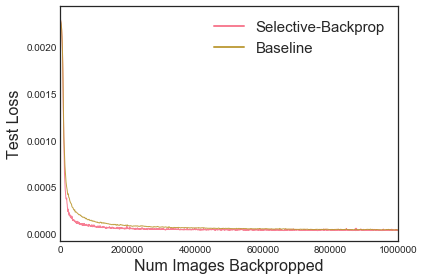

<Figure size 432x288 with 0 Axes>

In [15]:
plot_home_dir = "/Users/angela/research/filtered-training-presentations/pdl18/figs"
experiment_dir = "../data/output/mnist/"

plot_dir = "{}/181019_mnist/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

experiment_names = ["181019_mnist_square"]
plot_experiments(experiment_names,
                 experiment_dir,
                 plot_dir,
                 trials=[1],
                 sampling_mins=[0.1, 1],
                 xlim=1000000)
